In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [28]:
df_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', parse_dates=['Month'], index_col='Month')
df_rob = pd.read_csv('monthly-boston-armed-robberies-j.csv', parse_dates=['Month'], index_col='Month')

In [30]:
# Стационарный ряд (ограбления в Бостоне после преобразований)
df_rob['log'] = np.log(df_rob['Count'])
df_rob['diff'] = df_rob['log'].diff(1)
df_rob.dropna(inplace=True)

# Нестационарный ряд (температура воздуха)
df_temp.dropna(inplace=True)

In [32]:
# Разделение на обучающую и тестовую выборки
def train_test_split(data, test_size=0.2):
    split_idx = int(len(data) * (1 - test_size))
    return data[:split_idx], data[split_idx:]

In [34]:
# Для стационарного ряда
train_stat, test_stat = train_test_split(df_rob['diff'])

# Для нестационарного ряда
train_nonstat, test_nonstat = train_test_split(df_temp['Deg'])

In [36]:
# Функция для подбора модели MA
def fit_MA_model(data, q):
    model = ARIMA(data, order=(0, 0, q))  # (p=0, d=0, q=q) — модель MA(q)
    model_fit = model.fit()
    return model_fit

In [38]:
# Подбор моделей
# Для стационарного ряда
ma_stat = fit_MA_model(train_stat, q=1)
print(ma_stat.summary())

# Для нестационарного ряда
ma_nonstat = fit_MA_model(train_nonstat, q=1)
print(ma_nonstat.summary())

C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                   93
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  15.755
Date:                Tue, 04 Mar 2025   AIC                            -25.510
Time:                        22:59:23   BIC                            -17.913
Sample:                    02-01-1966   HQIC                           -22.443
                         - 10-01-1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.011      2.098      0.036       0.001       0.044
ma.L1         -0.4953      0.089     -5.557      0.000      -0.670      -0.321
sigma2         0.0416      0.006      6.630      0.0

C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    Deg   No. Observations:                  192
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -608.022
Date:                Tue, 04 Mar 2025   AIC                           1222.044
Time:                        22:59:23   BIC                           1231.817
Sample:                    01-01-1920   HQIC                          1226.002
                         - 12-01-1935                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9167      0.747     65.502      0.000      47.453      50.380
ma.L1          0.7711      0.052     14.908      0.000       0.670       0.872
sigma2        32.8177      4.191      7.830      0.0

In [39]:
# Прогнозирование
def forecast(model, test):
    forecast = model.predict(start=len(train_stat), end=len(train_stat) + len(test) - 1)
    return forecast

In [40]:
# Прогноз для стационарного ряда
forecast_stat = forecast(ma_stat, test_stat)

# Прогноз для нестационарного ряда
forecast_nonstat = forecast(ma_nonstat, test_nonstat)

In [41]:
# Оценка качества (среднеквадратичная ошибка)
mse_stat = mean_squared_error(test_stat, forecast_stat)
mse_nonstat = mean_squared_error(test_nonstat, forecast_nonstat)

print(f'MSE для стационарного ряда: {mse_stat}')
print(f'MSE для нестационарного ряда: {mse_nonstat}')

MSE для стационарного ряда: 0.02388433914226905
MSE для нестационарного ряда: 111.56059961302464


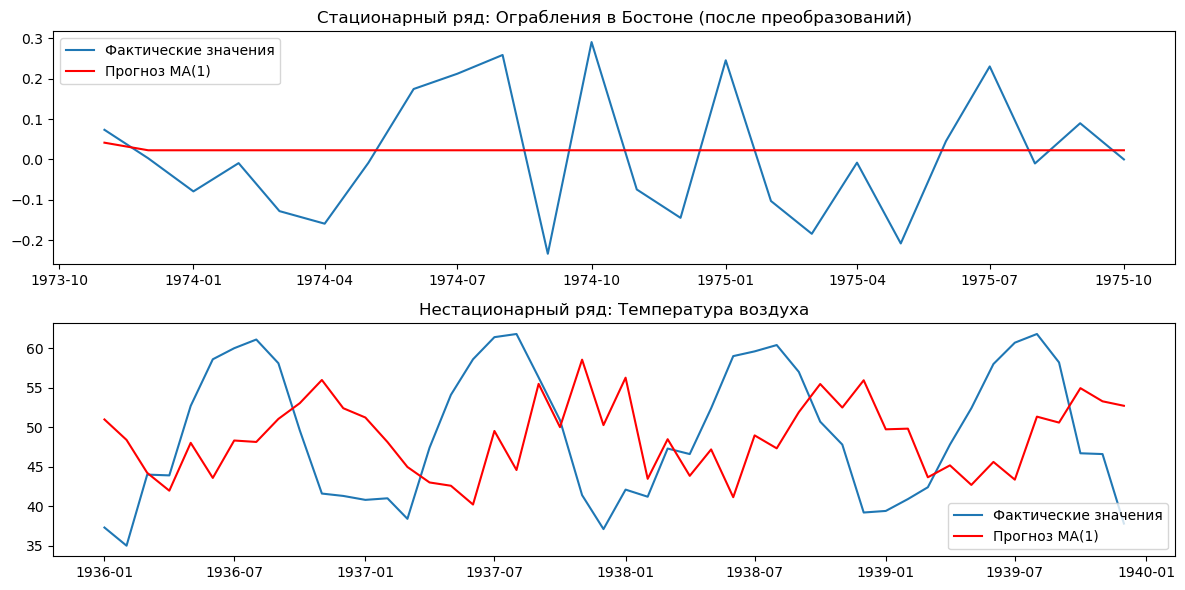

In [42]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

# Стационарный ряд
plt.subplot(2, 1, 1)
plt.plot(test_stat.index, test_stat, label='Фактические значения')
plt.plot(test_stat.index, forecast_stat, label='Прогноз MA(1)', color='red')
plt.title('Стационарный ряд: Ограбления в Бостоне (после преобразований)')
plt.legend()

# Нестационарный ряд
plt.subplot(2, 1, 2)
plt.plot(test_nonstat.index, test_nonstat, label='Фактические значения')
plt.plot(test_nonstat.index, forecast_nonstat, label='Прогноз MA(1)', color='red')
plt.title('Нестационарный ряд: Температура воздуха')
plt.legend()

plt.tight_layout()
plt.show()

## Выовды

Стационарный ряд:
- MSE низкий, так как модель MA хорошо подходит для стационарных данных

Нестационарный ряд:
- MSE делает туземун, так как модель MA не учитывает тренд и сезонность